<a href="https://colab.research.google.com/github/isabellacadisco/Human_Value_Detection_P2/blob/main/tests/P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -U transformers datasets evaluate accelerate

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 40.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 8.0.0
    Not uninstalling pyarrow at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-f320856f-a6ec-4b5c-aac4-99a07067f21b
    Can't uninstall 'pyarrow'. No files were found to uninstall.
  Attemp

In [ ]:
dbutils.library.restartPython()

In [ ]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

# for viz
import matplotlib.pyplot as plt

# Preparing for TPU usage
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()


2024-05-15 17:29:41.079234: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 17:29:41.079297: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 17:29:41.079320: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-15 17:29:41.086333: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy

In [ ]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=14930MB, multi_processor_count=40)

read data and merge on the document id

In [ ]:
# train
arg_training = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/arguments-training.tsv", delimiter='\t')
label_training = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/labels-training.tsv", delimiter= '\t')
df_training = pd.merge(arg_training, label_training, how='left', on="Argument ID")

In [ ]:
# validation
arg_validation = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/arguments-validation.tsv", delimiter='\t')
label_validation = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/labels-validation.tsv", delimiter= '\t')
df_validation = pd.merge(arg_validation, label_validation, how='left', on="Argument ID")



In [ ]:
# test
arg_test = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/arguments-test.tsv", delimiter='\t')
label_test = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/labels-test.tsv", delimiter= '\t')
df_test = pd.merge(arg_test, label_test, how='left', on="Argument ID")

visualize distribution of labels in the train, validation and test set

In [ ]:
df_training.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0


In [ ]:
df_training.iloc[:1, 1:4]

,Conclusion,Stance,Premise
0,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...


In [ ]:
print('premise: ' + df_training.loc[0, 'Premise']) # premessa
print('conclusion: ' + df_training.loc[0, 'Conclusion'])
print('stance: ' + df_training.loc[0, 'Stance']) # posizione

premise: we should ban human cloning as it will only cause huge issues when you have a bunch of the same humans running around all acting the same.
conclusion: We should ban human cloning
stance: in favor of


In [ ]:
print('premise: ' + df_training.loc[67, 'Premise'])
print('conclusion: ' + df_training.loc[67, 'Conclusion'])
print('stance: ' + df_training.loc[67, 'Stance'])

premise: libertarianism fosters a more equitable and efficient society for all
conclusion: We should adopt libertarianism
stance: in favor of


In [ ]:
print('premise: ' + df_training.loc[677, 'Premise'])
print('conclusion: ' + df_training.loc[677, 'Conclusion'])
print('stance: ' + df_training.loc[677, 'Stance'])

premise: algorithmic trading can cause unnatural market movements.
conclusion: We should ban algorithmic trading
stance: in favor of


as reported in the data source description (https://zenodo.org/records/10564870):

For the main purpose of the ValueEval shared task, <split> is one of:

training Arguments for training approaches (61%)
validation Arguments for validating (optimizing) approaches (21%)
test Arguments for testing approaches; labels were published after the competition (on 2023-04-29, 18%)

The distribution of argument sources is the same for training, validation, and test. Arguments with the same conclusion are always in the same split.

also we can see from the plot that the distribution of labels is similar in the three sets.

As they are defined from the authors of the Sem Eval 2023 competition, human values are our (humans!) convictions about what is good. Like is good to have own ideas, respect others, ..
Human values are not tied to specific circumstances, rather we emply them throughout our lives, values within you but also all around you.

- Politics -> election posters.
- Religion -> spiritual text.
- Economics -> perfect rational agents operating with perfect information, rational disagreement will still occur because for example the rational agents are likely to have different and inconsisten values and interests.

Human values are especially prominent in our discussions, our argumentations as externalization of our judgments and decisions. They reveal the values we resort to.

Human value detection focuses on automatically detect the values given a textual argument.

Data consist of short texts pairs(arguments):
- conclusion: the first statement, establish the context
- premise: draws upon values to argue either in favor or againsts the conclusion
- stance: Position of the premise towards the conclusion (Posizione della premessa verso la conclusione: binaria [in favor, against])

Algorithms task is to detect for each argument which values the premise draws upon.

Employ for this task a taxonomy of 20 value categories, based on social science research.
Sort of continuum of categories, with similarity between them, similar categories are next to each other.

An argument can resort to several categories: multilabel task, categories assigned independently of each other by the algorithm.

Possible to consider only subset of categories.


Since the model considered is pretty small compared to other LLM, as suggested in the competition task description, I will focus in the most frequent categories in the dataset: Self-direction: action, Achievement, Security: personal, Security: societal, Benevolence: caring, Universalism: concern.

As we can see from the following plots, these ones are the most frequent labels.

In [ ]:
def freq_plot_single(df):
  freq = df[df.columns[4:]].sum().sort_values(ascending=False)
  fig, ax = plt.subplots(figsize=(20, 10))
  freq.plot(kind='bar', ax=ax)
  ax.set_title('Labels frequency')
  ax.set_xlabel('Labels')
  ax.set_ylabel('Frequency')
  plt.show()


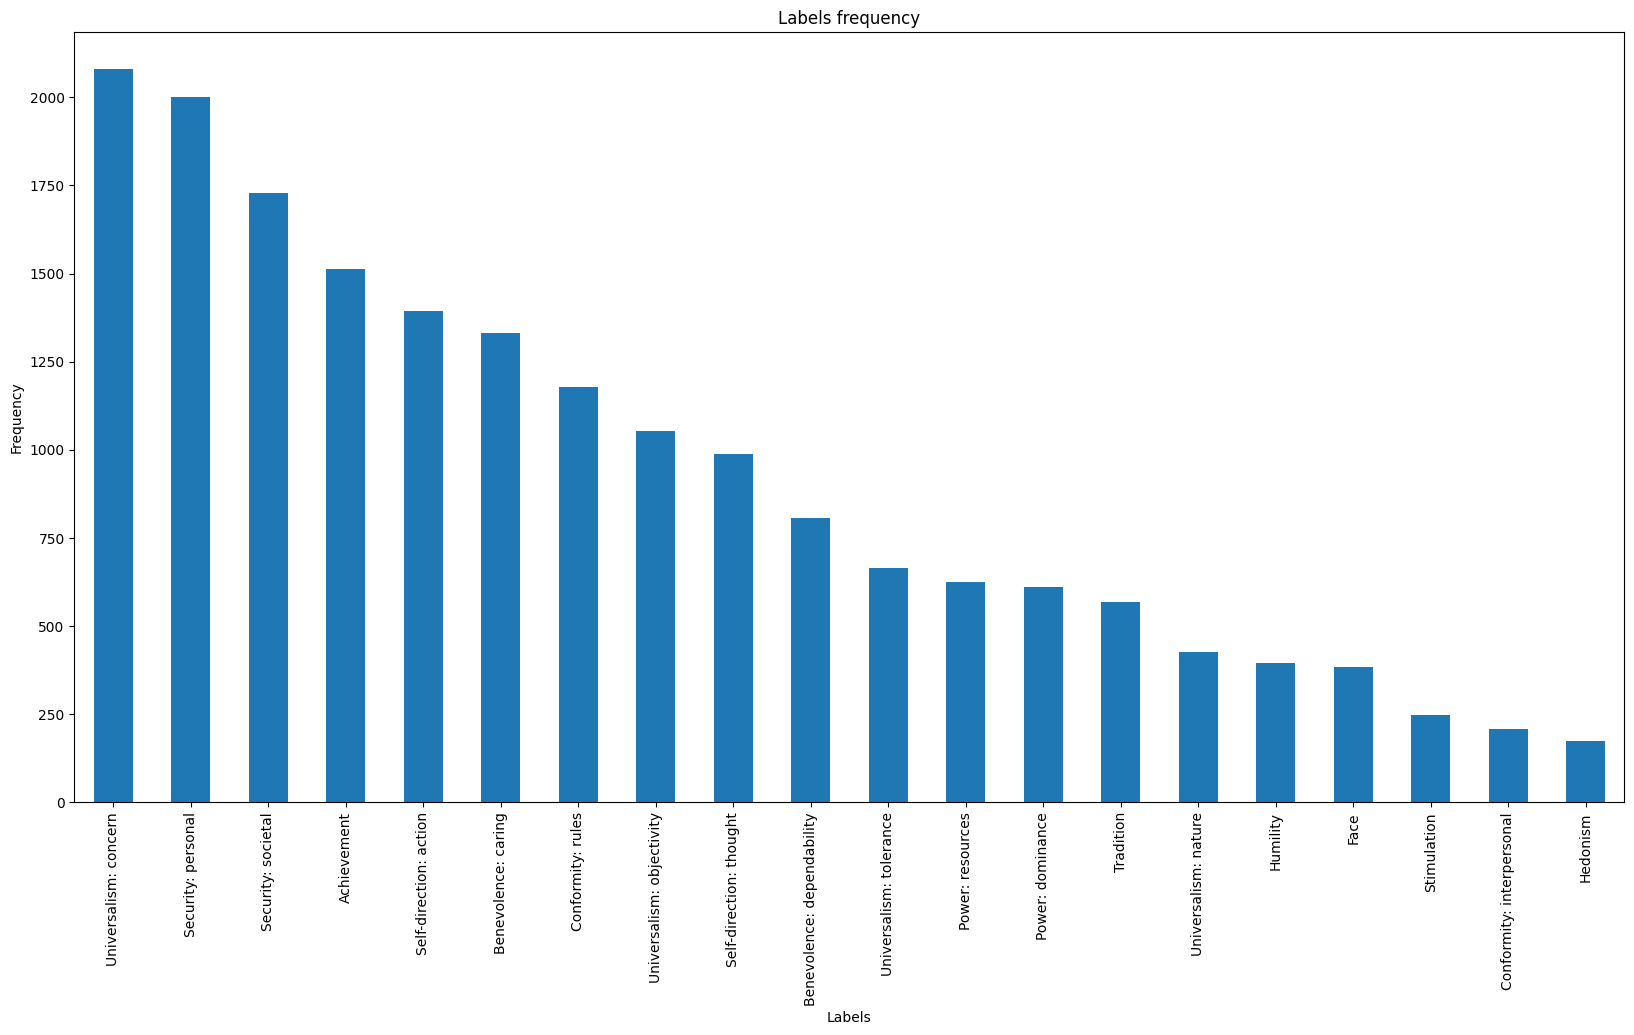

In [ ]:
freq_plot_single(df_training)

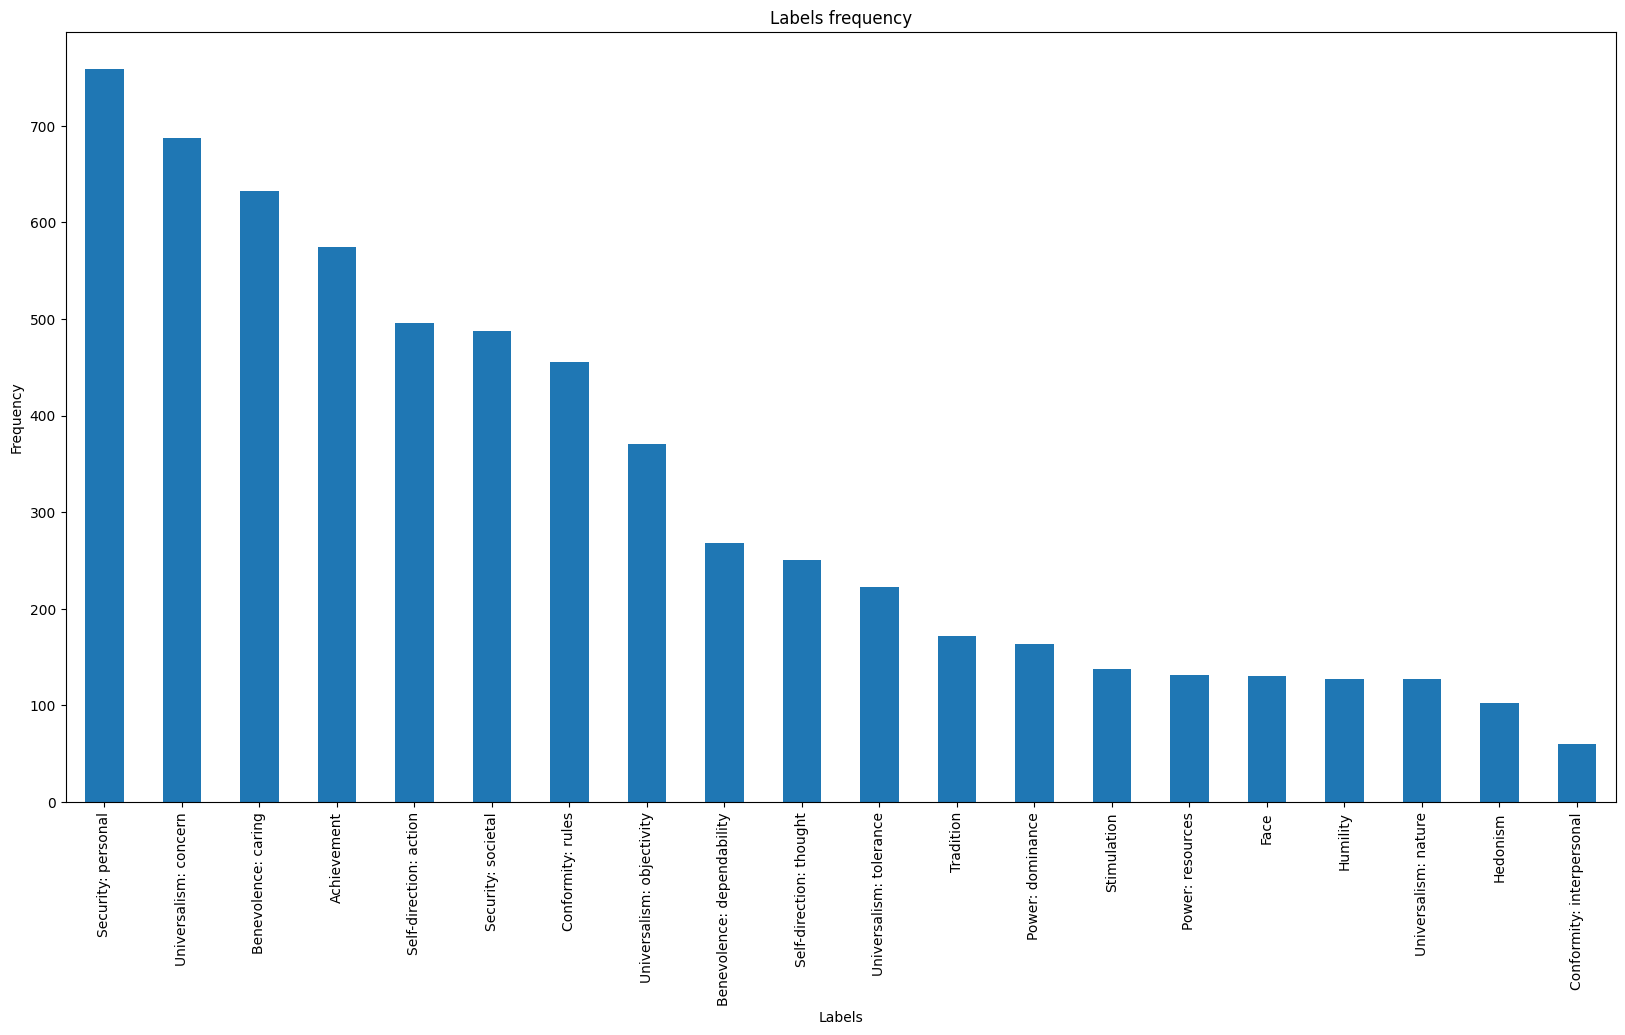

In [ ]:
freq_plot_single(df_validation)

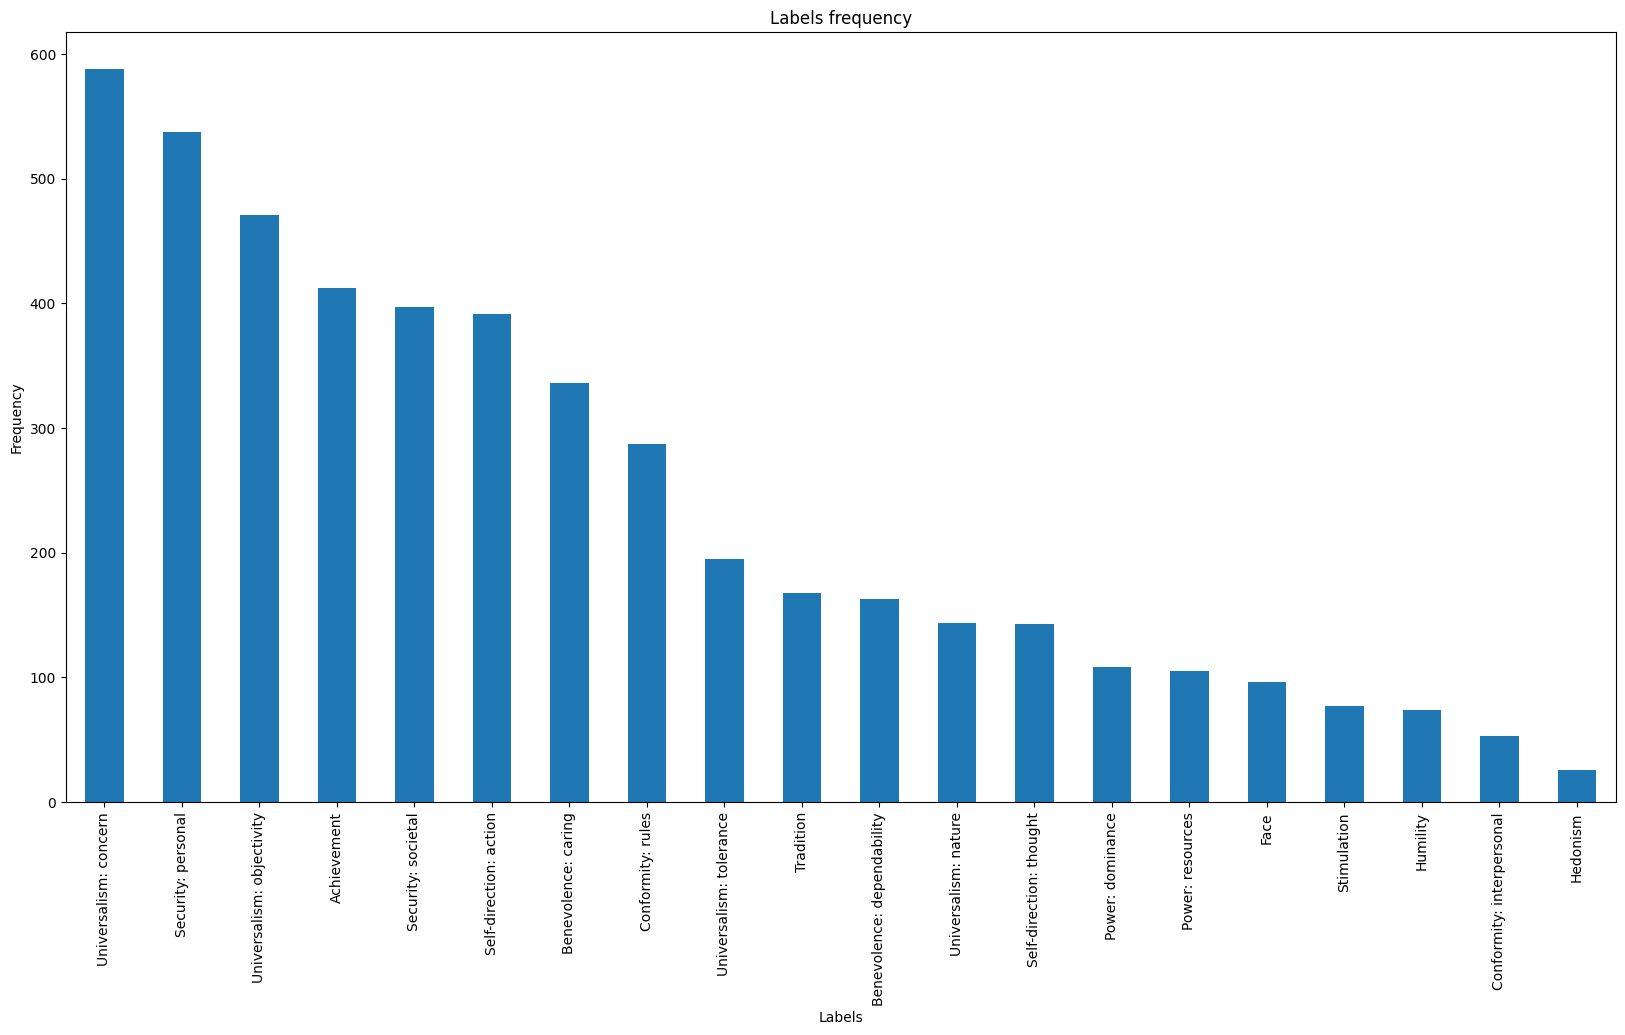

In [ ]:
freq_plot_single(df_test)

In [ ]:
selected_col = ['Argument ID', 'Conclusion', 'Stance', 'Premise','Self-direction: action', 'Achievement', 'Security: personal', 'Security: societal', 'Benevolence: caring', 'Universalism: concern']

subset_train = df_training[selected_col]
subset_val = df_validation[selected_col]
subset_test = df_test[selected_col]


In [ ]:
# number of labels we are interested in
len(selected_col)-4

6

In [ ]:
def freq_plot(train_df, val_df, test_df):

    train_freq = train_df[train_df.columns[4:]].sum()
    val_freq = val_df[val_df.columns[4:]].sum()
    test_freq = test_df[test_df.columns[4:]].sum()

    fig, ax = plt.subplots(figsize=(20, 10))

    train_freq.plot(kind='bar', ax=ax, color='blue', alpha=0.2, label='Train')
    val_freq.plot(kind='bar', ax=ax, color='yellow', alpha=0.4, label='Validation')
    test_freq.plot(kind='bar', ax=ax, color='red', alpha=0.6, label='Test')

    ax.set_title('Labels frequency')
    ax.set_xlabel('Labels')
    ax.set_ylabel('Frequency')

    ax.legend()
    plt.show()

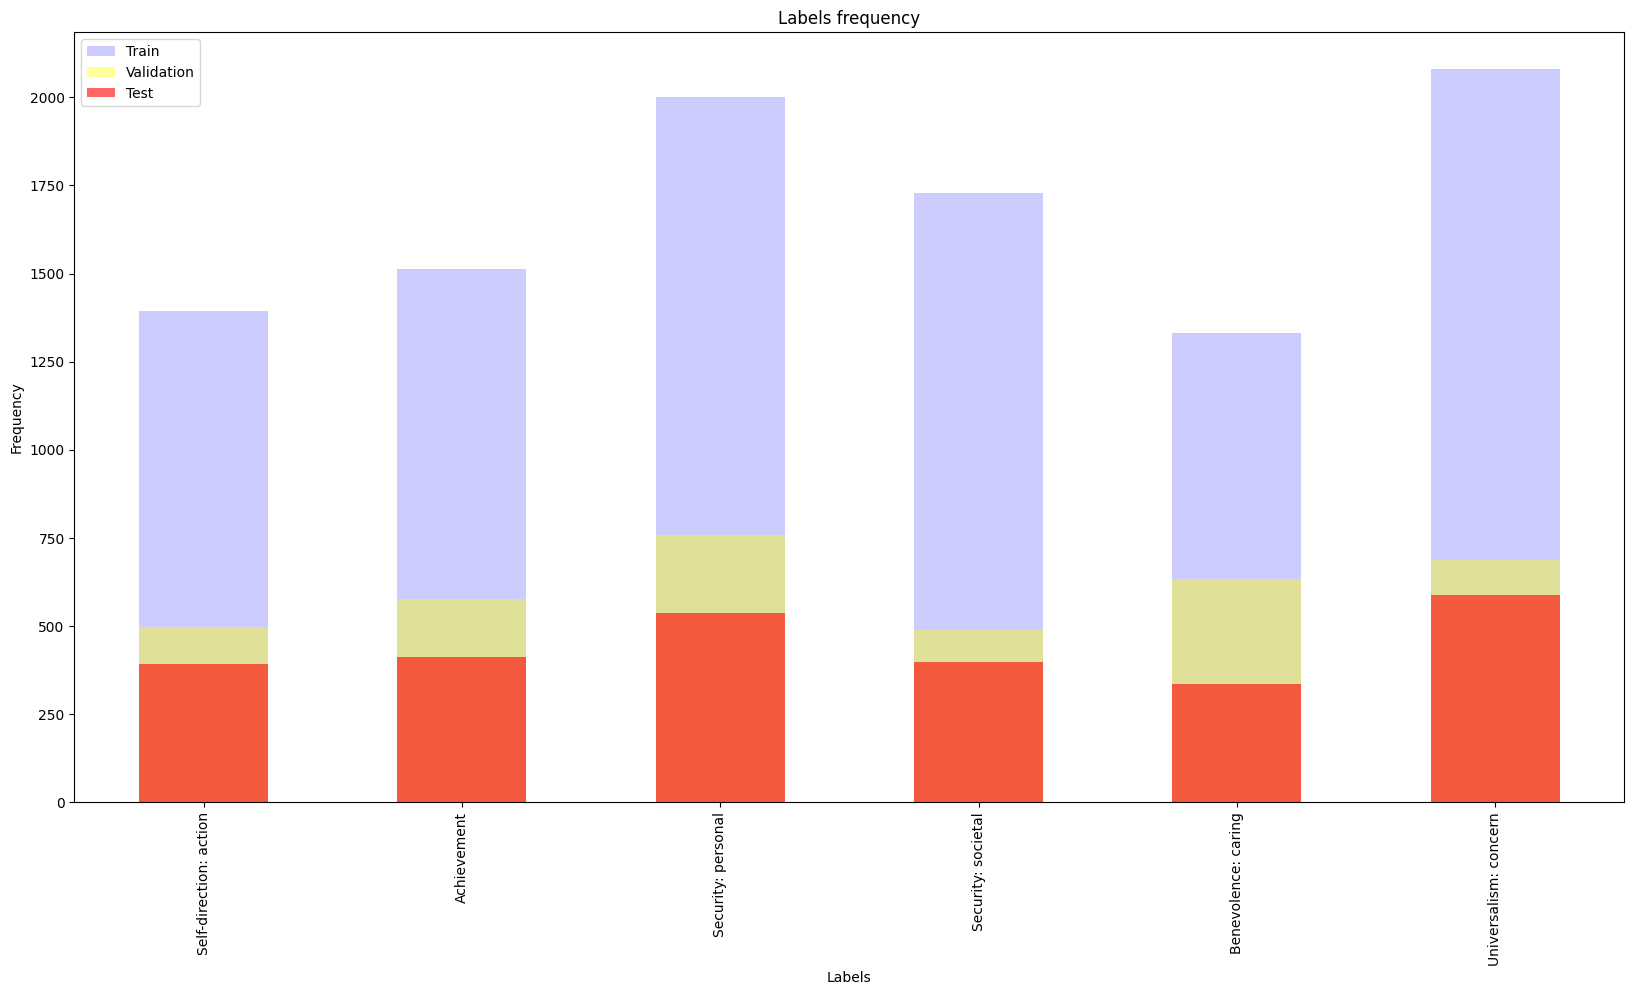

In [ ]:
freq_plot(subset_train, subset_val, subset_test)

co occurence matrix to see which labels are appearing together

each element (i, j) represents the count of data points where both label i and label j are present.

In [ ]:
def freq_co_mat(df):
  matrix = df[df.columns[4:]].T.dot(df[df.columns[4:]])
  fig, ax = plt.subplots(figsize=(20, 10))

  sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu", ax=ax)

  ax.set_title('Co-occurrencies')
  ax.set_xlabel('Labels')
  ax.set_ylabel('Labels')

  plt.show()


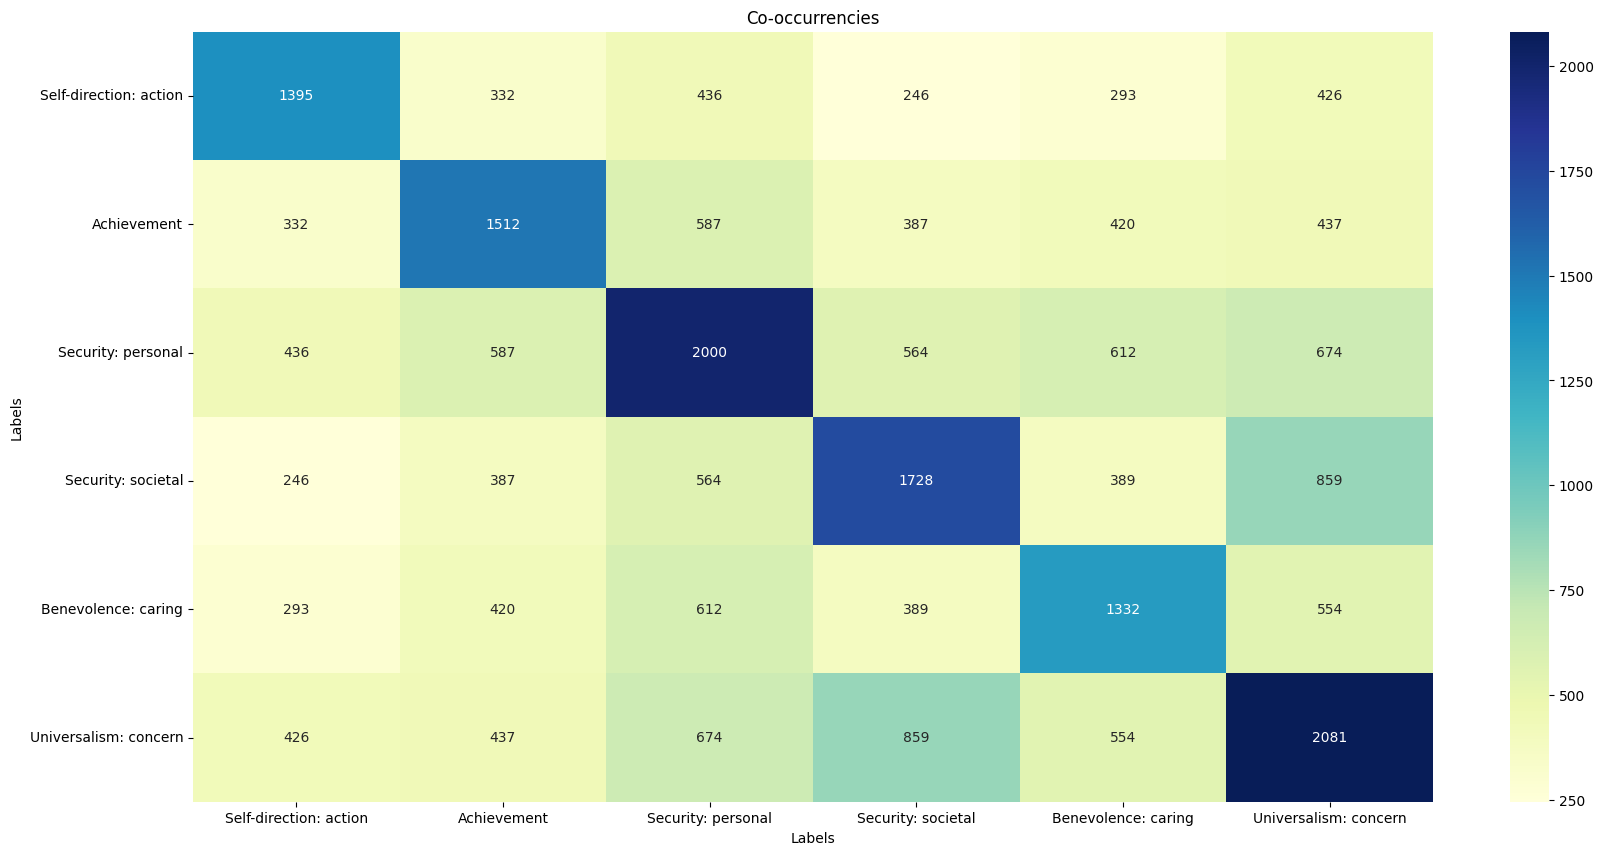

In [ ]:
freq_co_mat(subset_train)

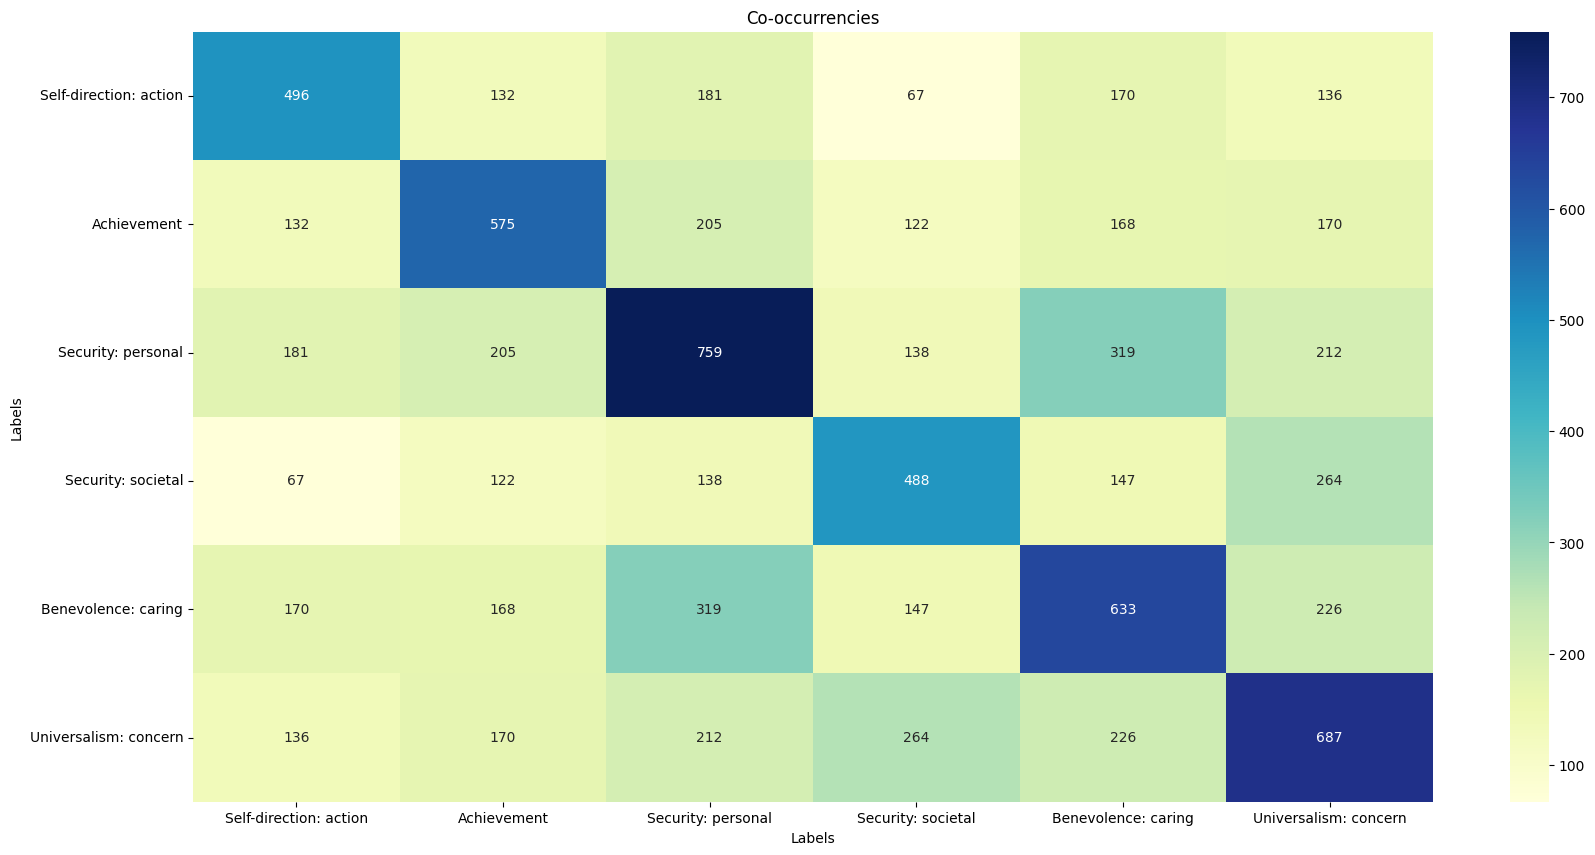

In [ ]:
freq_co_mat(subset_val)

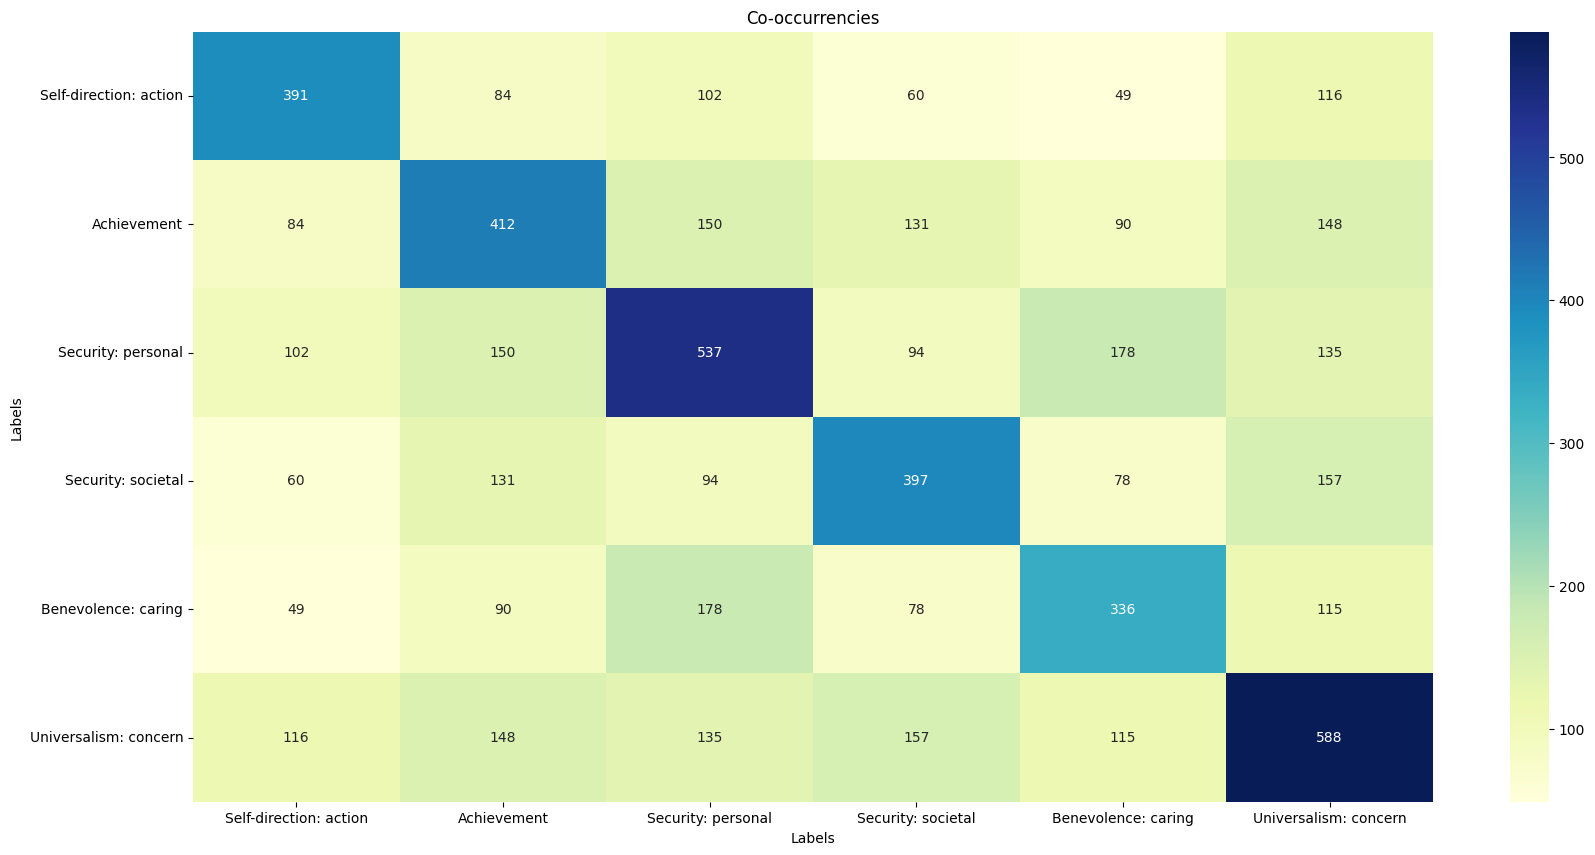

In [ ]:
freq_co_mat(subset_test)

For training purposes, we convert the values of the columns regarding categories in a list of binary values.

In [ ]:
subset_train['list'] = subset_train[subset_train.columns[4:]].values.tolist()
train_set = subset_train[['Premise', 'list']].copy()
train_set.head()

/root/.ipykernel/1424/command-1850711833658082-737349166:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train['list'] = subset_train[subset_train.columns[4:]].values.tolist()


,Premise,list
0,we should ban human cloning as it will only ca...,"[0, 0, 0, 1, 0, 0]"
1,fast food should be banned because it is reall...,"[0, 0, 1, 0, 0, 0]"
2,sometimes economic sanctions are the only thin...,"[0, 0, 0, 1, 0, 0]"
3,capital punishment is sometimes the only optio...,"[0, 0, 0, 1, 0, 1]"
4,factory farming allows for the production of c...,"[0, 0, 1, 0, 1, 1]"


In [ ]:
subset_val['list'] = subset_val[subset_val.columns[4:]].values.tolist()
val_set = subset_val[['Premise', 'list']].copy()
val_set.head()

/root/.ipykernel/1424/command-1850711833658096-977711949:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_val['list'] = subset_val[subset_val.columns[4:]].values.tolist()


,Premise,list
0,if entrapment can serve to more easily capture...,"[0, 0, 0, 1, 0, 0]"
1,the use of public defenders should be mandator...,"[0, 0, 0, 0, 0, 1]"
2,payday loans create a more impoverished societ...,"[0, 0, 1, 0, 0, 1]"
3,Surrogacy should not be banned as it is the wo...,"[1, 0, 0, 0, 0, 0]"
4,entrapment is gravely immoral and against huma...,"[0, 0, 0, 0, 0, 1]"


In [ ]:
subset_test['list'] = subset_test[subset_test.columns[4:]].values.tolist()
test_set = subset_test[['Premise', 'list']].copy()
test_set.head()

/root/.ipykernel/1424/command-1850711833658099-2477271213:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test['list'] = subset_test[subset_test.columns[4:]].values.tolist()


,Premise,list
0,affirmative action helps with employment equity.,"[0, 1, 1, 0, 0, 1]"
1,affirmative action can be considered discrimin...,"[0, 1, 0, 0, 0, 1]"
2,naturopathy is very dangerous for the most vul...,"[0, 1, 1, 0, 0, 1]"
3,women shouldn't be in combat because they aren...,"[0, 1, 0, 0, 0, 0]"
4,once eradicated illnesses are returning due to...,"[0, 1, 1, 1, 1, 0]"


Define variables used for fine tuning.
- creation of CustomDataset class: defines how the text is pre-processed before sending it to the NN
- Dataloader: will feed the data in batches both for training and processing

Both constructs of the PyTorch library https://pytorch.org/docs/stable/data.html

###### CustomDataset class
- This class is defined to accept the tokenizer, dataframe and max_length as input and generate tokenized output and tags that is used by the BERT model for training.
- We are using the BERT tokenizer to tokenize the data in the 'Premise' column of the dataframe.
- The tokenizer uses the encode_plus method to perform tokenization and generate the necessary outputs, namely: ids, attention_mask, token_type_ids

! In BERT, the tokenizer generates the token_type_ids as a necessary input for the model. Token type IDs are used to distinguish between the different segments of the input sequence, especially in tasks like sentence pair classification or question-answering, where two segments need to be distinguished. For example, in sentence pair classification, token_type_ids would be set to 0 for tokens corresponding to the first sentence and 1 for tokens corresponding to the second sentence.

However, in DistilBERT, token_type_ids are not explicitly required as input. DistilBERT removes the token_type_ids mechanism from BERT to reduce the model size and computational complexity. Instead, DistilBERT relies on a simpler architecture, where it distills the knowledge from the original BERT model into a smaller and more efficient version.

So, while token_type_ids are used in BERT to distinguish between segments, they are not explicitly used in DistilBERT due to its simplified architecture.

- targest is the list of categories labled as 0 or 1 in the dataframe.

###### Dataloader
- Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of dataloaded to the memory and then passed to the neural network needs to be controlled.
- This control is achieved using the parameters such as batch_size and max_len.
- Training and Validation dataloaders are used in the training and validation part of the flow respectively

In [ ]:
# variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/local_disk0/.ephemeral_nfs/envs/pythonEnv-f320856f-a6ec-4b5c-aac4-99a07067f21b/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_set.Premise

0       we should ban human cloning as it will only ca...
1       fast food should be banned because it is reall...
2       sometimes economic sanctions are the only thin...
3       capital punishment is sometimes the only optio...
4       factory farming allows for the production of c...
                              ...                        
5388    On the one hand, we have Russia killing countl...
5389    The subsidies were originally intended to ensu...
5390    These products come mainly from large enterpri...
5391    Subsidies often make farmers in recipient coun...
5392    The EU cannot endlessly lean on America or NAT...
Name: Premise, Length: 5393, dtype: object

In [ ]:
train_set.list

0       [0, 0, 0, 1, 0, 0]
1       [0, 0, 1, 0, 0, 0]
2       [0, 0, 0, 1, 0, 0]
3       [0, 0, 0, 1, 0, 1]
4       [0, 0, 1, 0, 1, 1]
               ...        
5388    [0, 1, 0, 1, 0, 0]
5389    [0, 0, 1, 0, 0, 1]
5390    [0, 0, 0, 0, 0, 0]
5391    [0, 0, 1, 1, 0, 1]
5392    [1, 0, 0, 1, 0, 0]
Name: list, Length: 5393, dtype: object

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.Premise = dataframe.Premise
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.Premise)

    def __getitem__(self, index):
        Premise = str(self.Premise[index])
        Premise = " ".join(Premise.split())

        inputs = self.tokenizer.encode_plus(
            Premise,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            #pad_to_max_length=True, deprecated
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)


In [ ]:
print("TRAIN Dataset: {}".format(train_set.shape))
print("TEST Dataset: {}".format(test_set.shape))

TRAIN Dataset: (5393, 2)
TEST Dataset: (1576, 2)


In [ ]:
training_set = CustomDataset(train_set, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_set, tokenizer, MAX_LEN)


In the context of PyTorch's DataLoader, the num_workers parameter specifies the number of subprocesses to use for data loading. These subprocesses are used to asynchronously load data, which can significantly speed up data loading, especially when dealing with large datasets or performing complex data transformations.

Here's what the num_workers parameter does:

When num_workers=0: Data loading is performed in the main process. No additional subprocesses are used for data loading. This setting is suitable for small datasets or when data loading speed is not a significant concern.

In [ ]:

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

######Neural Network for Fine Tuning

- BERTClass
- Bert model, followed by Dropout (Regularization) and a Linear Layer (Classification head)
- The second output output_1 or called the pooled output is passed to the Drop Out layer and the subsequent output is given to the Linear layer.

output_1 (or pooled output) is a fixed-size representation of the entire input sequence, derived from the output of the final transformer layer.

The final transformer output layer is a sequence of hidden states for each token in the input sequence, they contain rich contextual informatio about each token based on its surrounding context in the sequence.


Sequence output is the sequence of hidden-states (embeddings) at the output of the last layer of the BERT model. It includes the embedding of the [CLS] token. Hence, for the sentence "You are on Stackoverflow", it gives 5 embeddings: one embedding for each of the four words (assuming the word "Stackoverflow" was tokenized into a single token) along with the embedding of the [CLS] token. Pooled output is the embedding of the [CLS] token (from Sequence output), further processed by a Linear layer and a Tanh activation function. The Linear layer weights are trained from the next sentence prediction (classification) objective during pretraining.

- Linear Layer has dimension equal to the total number of categories, which in this case is 6 ('Self-direction: action', 'Achievement', 'Security: personal', 'Security: societal', 'Benevolence: caring', 'Universalism: concern').

- Final layer outputs are used to calculate the loss and to determine the accuracy of the model prediction.

- Our model will be an instance of the network, used for training and to save the final trained model for future inference.



####### Loss Function and Optimizer
- combination of Binary Cross Entropy which is implemented as BCELogits Loss in PyTorch
- Optimizer,to update weights Adam

## soluzione che funziona ma forse dovrei capire meglio

 output_1 is not a tensor but an instance of BaseModelOutputWithPoolingAndCrossAttentions, which is the expected output of the transformers.BertModel.

To access the tensor from output_1, you need to retrieve the pooler_output attribute, which contains the pooled output tensor. Here's how you can modify your forward method to extract the tensor:

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.2) # provo 0.2
        self.l3 = torch.nn.Linear(768, 6)

    def forward(self, ids, mask, token_type_ids):

        outputs = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids)
        output_1 = outputs.pooler_output #!!!

        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-f320856f-a6ec-4b5c-aac4-99a07067f21b/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

####### Fine tuning the model
Define a training function to train the model on the specified number of EPOCHS.
1 epoch = a complete pass over the training data through the network.
- dataloader passe he data to the model, based on batch size.
- outputs of the model and the actual categories are used to compute the loss.
- the weights of the neurons are optimized wrt the loss
- print loss value every 2000 steps.

def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%2000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    train(epoch)

In [ ]:
def validation(epoch):
    model.eval()

    fin_targets=[]
    fin_outputs=[]

    with torch.no_grad(): #disable gradient calculation, useful for evaluation
        for _, data in enumerate(testing_loader, 0):

            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
def train(epoch):
    model.train()

    t_fin_targets=[]
    t_fin_outputs=[]

    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        t_fin_targets.extend(targets.cpu().detach().numpy().tolist())
        # apply SIGMOID to get multilabel predictions
        t_fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%2000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return t_fin_outputs, t_fin_targets, loss.item() # not correct, i should return avg loss for all batches

In [ ]:
metrics_train_eval = {}

In [ ]:
for epoch in range(EPOCHS):

    print(f'Epoch: {epoch}')

    # training ----------------------------------------------------------------
    train_outputs, train_targets, train_loss = train(epoch)
    # put to 1 predictions with value >= 0.5
    train_outputs = np.array(train_outputs) >= 0.5

    train_accuracy = metrics.accuracy_score(train_targets, train_outputs)
    train_f1_score_micro = metrics.f1_score(train_targets, train_outputs, average='micro')
    train_f1_score_macro = metrics.f1_score(train_targets, train_outputs, average='macro')

    metrics_train_eval[epoch] = {'Train Accuracy Score' : train_accuracy,
                        'Train F1 Score (Micro)' : train_f1_score_micro,
                        'Train F1 Score (Macro)' : train_f1_score_macro}

    print(f"Train Accuracy Score = {train_accuracy}")
    print(f"Train F1 Score (Micro) = {train_f1_score_micro}")
    print(f"Train F1 Score (Macro) = {train_f1_score_macro}")
    print(f"Train loss = {train_loss}")


    # validation --------------------------------------------------------------

    eval_outputs, eval_targets = validation(epoch)
    # put to 1 predictions with value >= 0.5
    eval_outputs = np.array(eval_outputs) >= 0.5

    eval_accuracy = metrics.accuracy_score(eval_targets, eval_outputs)
    eval_f1_score_micro = metrics.f1_score(eval_targets, eval_outputs, average='micro')
    eval_f1_score_macro = metrics.f1_score(eval_targets, eval_outputs, average='macro')

    metrics_train_eval[epoch].update({
        'Eval Accuracy Score': eval_accuracy,
        'Eval F1 Score (Micro)': eval_f1_score_micro,
        'Eval F1 Score (Macro)': eval_f1_score_macro
    })

    print(f"Eval Accuracy Score = {eval_accuracy}")
    print(f"Eval F1 Score (Micro) = {eval_f1_score_micro}")
    print(f"Eval F1 Score (Macro) = {eval_f1_score_macro}")

    print('-------------------------------------------------------------------')

Epoch: 0
Epoch: 0, Loss:  0.767402172088623
Train Accuracy Score = 0.15705544223994067
Train F1 Score (Micro) = 0.3794996079549505
Train F1 Score (Macro) = 0.333695147926189
Train loss = 0.19481121003627777
Eval Accuracy Score = 0.2233502538071066
Eval F1 Score (Micro) = 0.5544309027060524
Eval F1 Score (Macro) = 0.4661736776640361
-------------------------------------------------------------------
Epoch: 1
Epoch: 1, Loss:  0.5348178148269653
Train Accuracy Score = 0.28314481735583164
Train F1 Score (Micro) = 0.6164866134335368
Train F1 Score (Macro) = 0.5721528855897137
Train loss = 0.20844191312789917
Eval Accuracy Score = 0.25888324873096447
Eval F1 Score (Micro) = 0.5972416550069958
Eval F1 Score (Macro) = 0.551841050519679
-------------------------------------------------------------------
Epoch: 2
Epoch: 2, Loss:  0.32459557056427
Train Accuracy Score = 0.3610235490450584
Train F1 Score (Micro) = 0.7040268456375839
Train F1 Score (Macro) = 0.6722857046400085
Train loss = 0.623753

In [ ]:
metrics_train_eval

{0: {'Train Accuracy Score': 0.15705544223994067,
  'Train F1 Score (Micro)': 0.3794996079549505,
  'Train F1 Score (Macro)': 0.333695147926189,
  'Eval Accuracy Score': 0.2233502538071066,
  'Eval F1 Score (Micro)': 0.5544309027060524,
  'Eval F1 Score (Macro)': 0.4661736776640361},
 1: {'Train Accuracy Score': 0.28314481735583164,
  'Train F1 Score (Micro)': 0.6164866134335368,
  'Train F1 Score (Macro)': 0.5721528855897137,
  'Eval Accuracy Score': 0.25888324873096447,
  'Eval F1 Score (Micro)': 0.5972416550069958,
  'Eval F1 Score (Macro)': 0.551841050519679},
 2: {'Train Accuracy Score': 0.3610235490450584,
  'Train F1 Score (Micro)': 0.7040268456375839,
  'Train F1 Score (Macro)': 0.6722857046400085,
  'Eval Accuracy Score': 0.282994923857868,
  'Eval F1 Score (Micro)': 0.6316196366447623,
  'Eval F1 Score (Macro)': 0.6069640181829067},
 3: {'Train Accuracy Score': 0.45355089931392545,
  'Train F1 Score (Micro)': 0.7795661301609518,
  'Train F1 Score (Macro)': 0.7582562542181993,

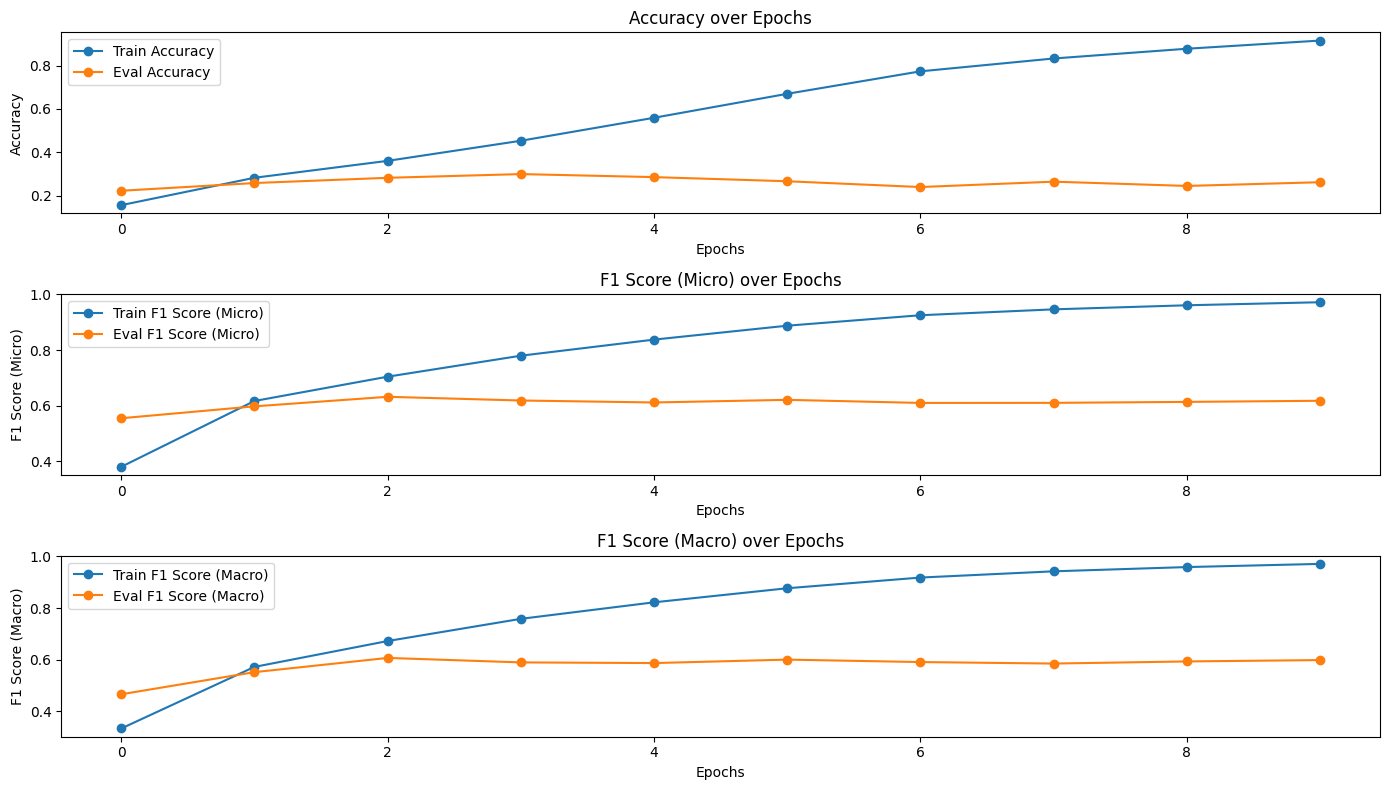

In [ ]:
# extract metrics
epochs = list(metrics_train_eval.keys())
train_accuracy = [metrics_train_eval[epoch]['Train Accuracy Score'] for epoch in epochs]
eval_accuracy = [metrics_train_eval[epoch]['Eval Accuracy Score'] for epoch in epochs]
train_f1_micro = [metrics_train_eval[epoch]['Train F1 Score (Micro)'] for epoch in epochs]
eval_f1_micro = [metrics_train_eval[epoch]['Eval F1 Score (Micro)'] for epoch in epochs]
train_f1_macro = [metrics_train_eval[epoch]['Train F1 Score (Macro)'] for epoch in epochs]
eval_f1_macro = [metrics_train_eval[epoch]['Eval F1 Score (Macro)'] for epoch in epochs]

# plot fig
plt.figure(figsize=(14, 8))

# accuracy plot
plt.subplot(3, 1, 1)
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, eval_accuracy, label='Eval Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# F1 micro plot
plt.subplot(3, 1, 2)
plt.plot(epochs, train_f1_micro, label='Train F1 Score (Micro)', marker='o')
plt.plot(epochs, eval_f1_micro, label='Eval F1 Score (Micro)', marker='o')
plt.title('F1 Score (Micro) over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score (Micro)')
plt.legend()

# F1 macro plot
plt.subplot(3, 1, 3)
plt.plot(epochs, train_f1_macro, label='Train F1 Score (Macro)', marker='o')
plt.plot(epochs, eval_f1_macro, label='Eval F1 Score (Macro)', marker='o')
plt.title('F1 Score (Macro) over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score (Macro)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
selected_col[4:]

['Self-direction: action',
 'Achievement',
 'Security: personal',
 'Security: societal',
 'Benevolence: caring',
 'Universalism: concern']

In [ ]:
test_set.head(1)

,Premise,list
0,affirmative action helps with employment equity.,"[0, 1, 1, 0, 0, 1]"


In [ ]:
test_item_0 = testing_set.__getitem__(0)
ids = test_item_0['ids'].to(device, dtype = torch.long)
mask = test_item_0['mask'].to(device, dtype = torch.long)
token_type_ids = test_item_0['token_type_ids'].to(device, dtype = torch.long)
targets = test_item_0['targets'] #

# disable gradient calculation, add an extra dimension to the input tensors using unsqueeze(0) to create a batch of size 1.
with torch.no_grad():
    outputs = model(ids.unsqueeze(0), mask.unsqueeze(0), token_type_ids.unsqueeze(0))

print("Model Output:", outputs)

outputs = torch.sigmoid(outputs).cpu().detach().numpy().tolist()
print("Model Output after SIGMOID:", outputs)

outputs = np.array(outputs) >= 0.5

# model's output and the actual target
print("Model Output threshold:", outputs)
print("Actual Target:", targets)

Model Output: tensor([[-6.5785,  5.2163,  0.8269, -5.3690, -0.2159,  3.6585]],
       device='cuda:0')
Model Output after SIGMOID: [[0.0013879956677556038, 0.994601845741272, 0.6956973075866699, 0.004637016449123621, 0.44623368978500366, 0.9748773574829102]]
Model Output threshold: [[False  True  True False False  True]]
Actual Target: tensor([0., 1., 1., 0., 0., 1.])


In [ ]:
# flat the outputs and targets arrays
outputs_flat = np.ravel(outputs)
targets_flat = np.ravel(targets)

print("Accuracy Score:", metrics.accuracy_score(targets_flat, outputs_flat))
print("F1 micro Score:", metrics.f1_score(targets_flat, outputs_flat, average='micro'))
print("F1 macro Score:", metrics.f1_score(targets_flat, outputs_flat, average='macro'))

Accuracy Score: 1.0
F1 micro Score: 1.0
F1 macro Score: 1.0


In [ ]:
test_set[87:88]

,Premise,list
87,marriage is antiquated and does not provide mu...,"[0, 0, 1, 0, 0, 1]"


In [ ]:
test_item_0 = testing_set.__getitem__(87)
ids = test_item_0['ids'].to(device, dtype = torch.long)
mask = test_item_0['mask'].to(device, dtype = torch.long)
token_type_ids = test_item_0['token_type_ids'].to(device, dtype = torch.long)
targets = test_item_0['targets'] #

# disable gradient calculation, add an extra dimension to the input tensors using unsqueeze(0) to create a batch of size 1.
with torch.no_grad():
    outputs = model(ids.unsqueeze(0), mask.unsqueeze(0), token_type_ids.unsqueeze(0))

print("Model Output:", outputs)

outputs = torch.sigmoid(outputs).cpu().detach().numpy().tolist()
print("Model Output after SIGMOID:", outputs)

outputs = np.array(outputs) >= 0.5

# model's output and the actual target
print("Model Output threshold:", outputs)
print("Actual Target:", targets)

Model Output: tensor([[-6.2945,  6.6320,  4.3166,  0.8823, -3.6947, -1.7174]],
       device='cuda:0')
Model Output after SIGMOID: [[0.0018430358031764627, 0.9986842274665833, 0.9868300557136536, 0.7072995901107788, 0.0242511834949255, 0.15220677852630615]]
Model Output threshold: [[False  True  True  True False False]]
Actual Target: tensor([0., 0., 1., 0., 0., 1.])


In [ ]:
# flat the outputs and targets arrays
outputs_flat = np.ravel(outputs)
targets_flat = np.ravel(targets)

print("Accuracy Score:", metrics.accuracy_score(targets_flat, outputs_flat))
print("F1 micro Score:", metrics.f1_score(targets_flat, outputs_flat, average='micro'))
print("F1 macro Score:", metrics.f1_score(targets_flat, outputs_flat, average='macro'))

Accuracy Score: 0.5
F1 micro Score: 0.5
F1 macro Score: 0.48571428571428577


In [ ]:
test_set[1456:1457]

,Premise,list
1456,Immigrants from non-European countries are als...,"[0, 0, 0, 0, 0, 0]"


In [ ]:
test_item_0 = testing_set.__getitem__(1456)
ids = test_item_0['ids'].to(device, dtype = torch.long)
mask = test_item_0['mask'].to(device, dtype = torch.long)
token_type_ids = test_item_0['token_type_ids'].to(device, dtype = torch.long)
targets = test_item_0['targets'] #

# disable gradient calculation, add an extra dimension to the input tensors using unsqueeze(0) to create a batch of size 1.
with torch.no_grad():
    outputs = model(ids.unsqueeze(0), mask.unsqueeze(0), token_type_ids.unsqueeze(0))

print("Model Output:", outputs)

outputs = torch.sigmoid(outputs).cpu().detach().numpy().tolist()
print("Model Output after SIGMOID:", outputs)

outputs = np.array(outputs) >= 0.5

# model's output and the actual target
print("Model Output threshold:", outputs)
print("Actual Target:", targets)

Model Output: tensor([[-3.4932, -1.1693,  0.0900,  3.5030, -6.2780, -5.8796]],
       device='cuda:0')
Model Output after SIGMOID: [[0.02950676530599594, 0.23698389530181885, 0.5224882960319519, 0.9707739353179932, 0.0018736965721473098, 0.002788236830383539]]
Model Output threshold: [[False False  True  True False False]]
Actual Target: tensor([0., 0., 0., 0., 0., 0.])


In [ ]:
# flat the outputs and targets arrays
outputs_flat = np.ravel(outputs)
targets_flat = np.ravel(targets)

print("Accuracy Score:", metrics.accuracy_score(targets_flat, outputs_flat))
print("F1 micro Score:", metrics.f1_score(targets_flat, outputs_flat, average='micro'))
print("F1 macro Score:", metrics.f1_score(targets_flat, outputs_flat, average='macro'))

Accuracy Score: 0.6666666666666666
F1 micro Score: 0.6666666666666666
F1 macro Score: 0.4
